In [76]:
import warnings

%load_ext autoreload
%autoreload 2

from torsion import fetch_pdb, load_pdb
from torsion import phi_psi_angles, ram_plot

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def ram_from_pdb_id(pdb_id, density=True):
    "helper function to plot RAM for given PDB ID"
    pdb_struct = fetch_pdb(pdb_id)
    ram_plot(*phi_psi_angles(pdb_struct), pdb_id, density=density)
    
def ram_from_pdb_file(pdb_file, pdb_id, density=True):
    "helper function to plot RAM from .cif file"
    pdb_struct = load_pdb(pdb_file)
    ram_plot(*phi_psi_angles(pdb_struct), pdb_id, density=density)

## Reduced (CuI) poplar plastocyanin: 6PCY

<img src="figs/6PCY.png" width="300"/>

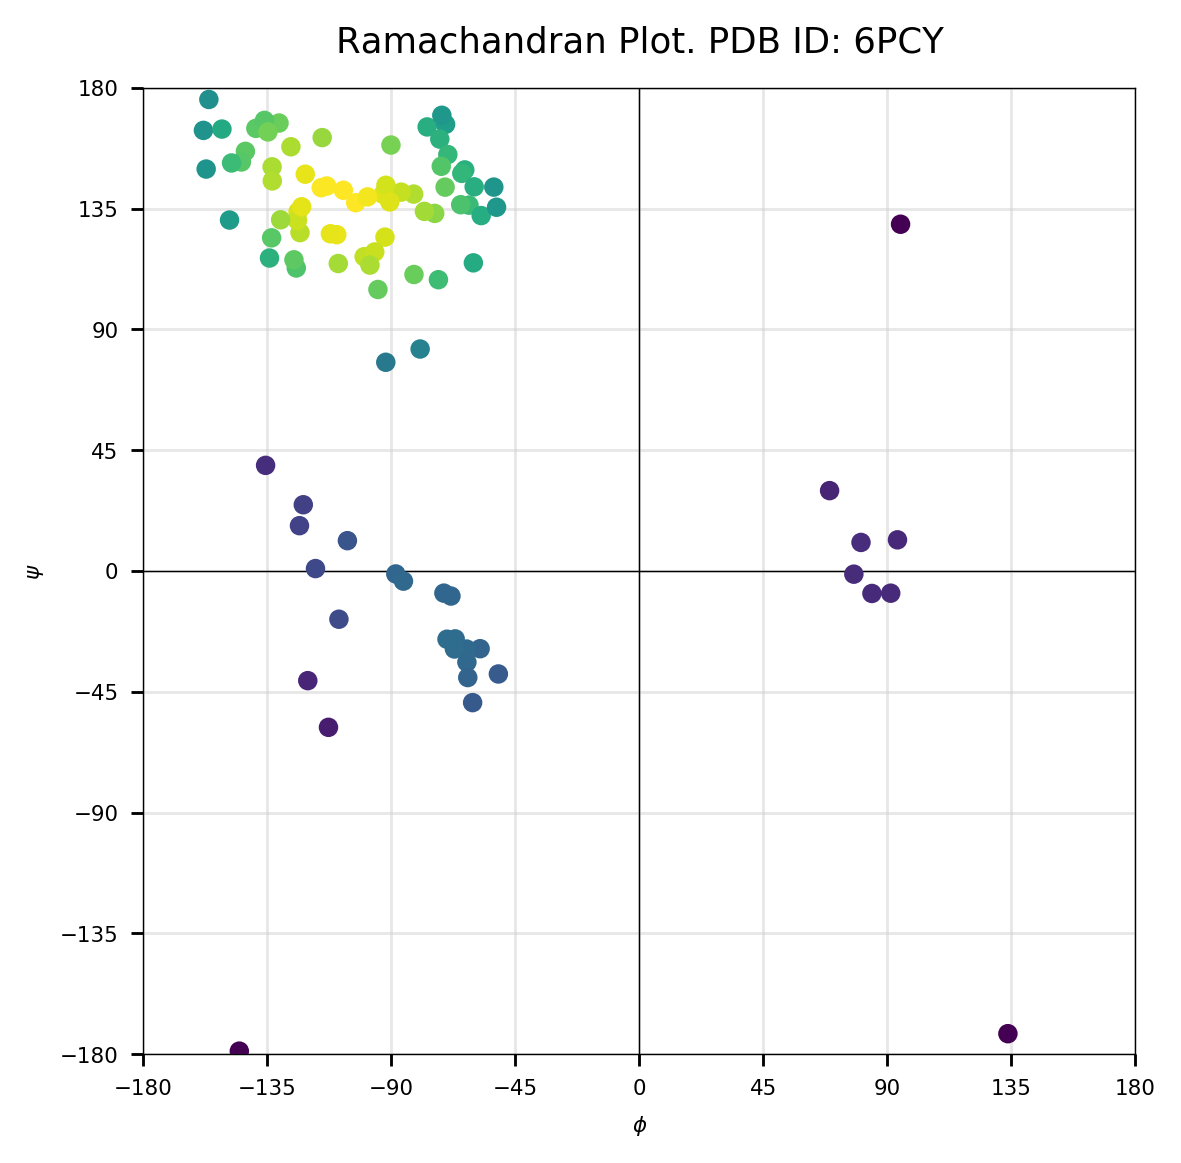

In [92]:
ram_from_pdb_id("6PCY")

## Human Prolidase: 2IW2

<img src="figs/2IW2.png" width="300"/>

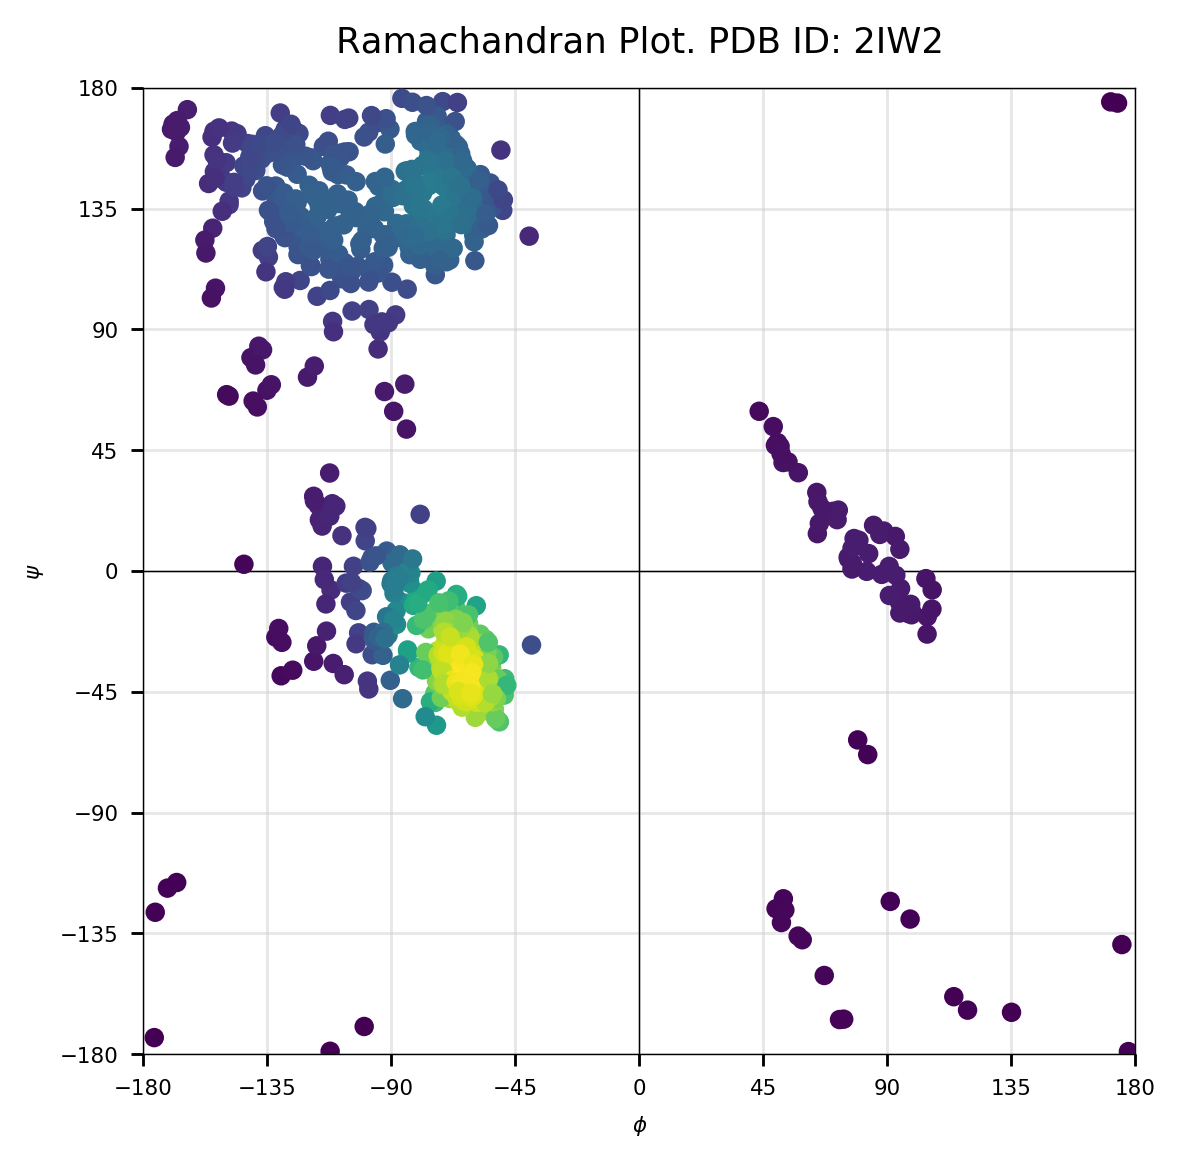

In [93]:
ram_from_pdb_id("2IW2")

## Immunoglobulin: 1IGT

<img src="figs/1IGT.png" width="300"/>

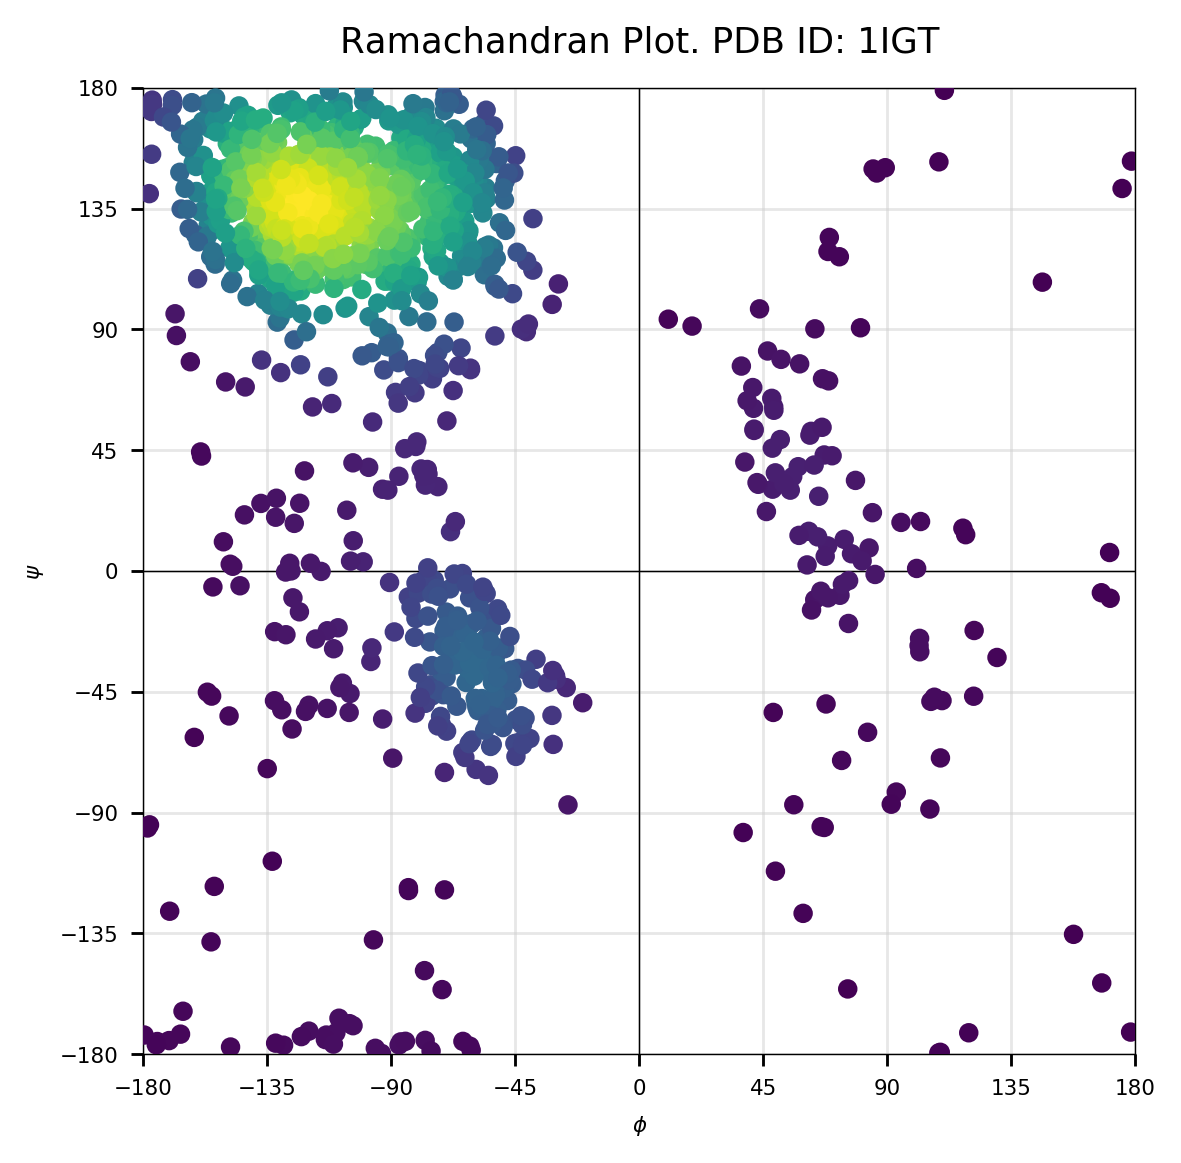

In [94]:
ram_from_pdb_id("1IGT")

# Additional

## Structure of novel coronavirus spike receptor-binding domain complexed with its receptor ACE2 (Angiotensin-converting enzyme 2): 6LZG 

<img src="figs/6LZG.png" width="300"/>

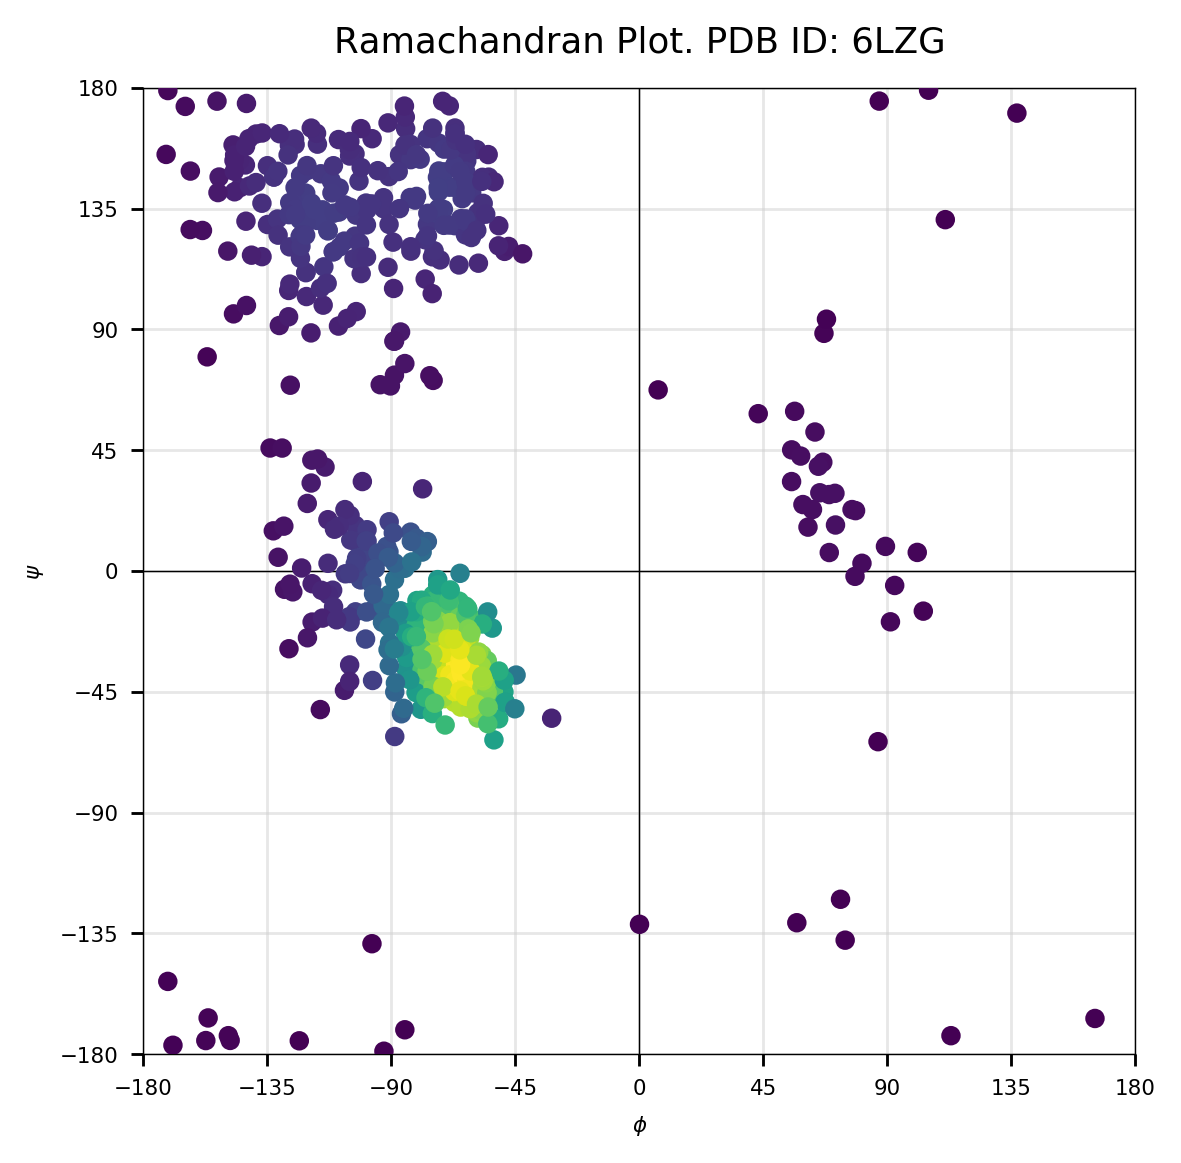

In [95]:
ram_from_pdb_id("6LZG")

# References

- https://xn--n1afeh.xn--80abvyzg.xn--p1ai/%D0%BC%D0%BE%D0%BB%D0%B5%D0%BA%D1%83%D0%BB%D1%8B/%D0%A0%D0%B0%D0%BC%D0%B0%D1%87%D0%B0%D0%BD%D0%B4%D1%80%D0%B0%D0%BD.html#lookL
- https://www.youtube.com/watch?v=Q1ftYq13XKk
- http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc163